In [1]:
# Cell 1: Load models and data
import pandas as pd
import joblib
import json

# Load models
recovery_model = joblib.load('../models/recovery_classifier.pkl')
hrv_model = joblib.load('../models/hrv_predictor.pkl')
injury_model = joblib.load('../models/injury_risk_classifier.pkl')

# Load config
with open('../models/model_config.json') as f:
    config = json.load(f)[0]

# Load latest data
df = pd.read_csv('../data/processed/training_dataset.csv')
df['date'] = pd.to_datetime(df['date'])

print("✓ Models loaded")
print(f"Data: {df['date'].min()} to {df['date'].max()}")


✓ Models loaded
Data: 2025-11-23 00:00:00 to 2025-12-17 00:00:00


In [4]:
# Cell 2: Test prediction for today (UPDATED - no warnings)
latest = df.iloc[-1]

# Prepare features as DataFrame (preserves column names)
recovery_features = config['recovery_features']
X_recovery = latest[recovery_features].to_frame().T  # DataFrame instead of array

# Predict
ready = recovery_model.predict(X_recovery)[0]
ready_proba = recovery_model.predict_proba(X_recovery)[0]

print(f"Date: {latest['date']}")
print(f"\nRECOVERY STATUS:")
print(f"  Ready for hard workout: {'YES ✓' if ready else 'NO - Easy/Rest recommended'}")
print(f"  Confidence: {ready_proba[ready]*100:.1f}%")

# HRV prediction
X_hrv = latest[config['hrv_features']].to_frame().T
predicted_hrv = hrv_model.predict(X_hrv)[0]
print(f"\nPREDICTED HRV TOMORROW: {predicted_hrv:.1f} ms")
print(f"  (Current: {latest['hrv_rmssd']:.1f} ms)")

# Injury risk
X_injury = latest[config['injury_features']].to_frame().T
injury_risk = injury_model.predict_proba(X_injury)[0][1]
print(f"\nINJURY RISK (next 7 days): {injury_risk*100:.1f}%")
if injury_risk > 0.3:
    print("  ⚠️ WARNING: Elevated risk detected!")


Date: 2025-12-17 00:00:00

RECOVERY STATUS:
  Ready for hard workout: NO - Easy/Rest recommended
  Confidence: 76.7%

PREDICTED HRV TOMORROW: 85.5 ms
  (Current: 79.0 ms)

INJURY RISK (next 7 days): 13.0%


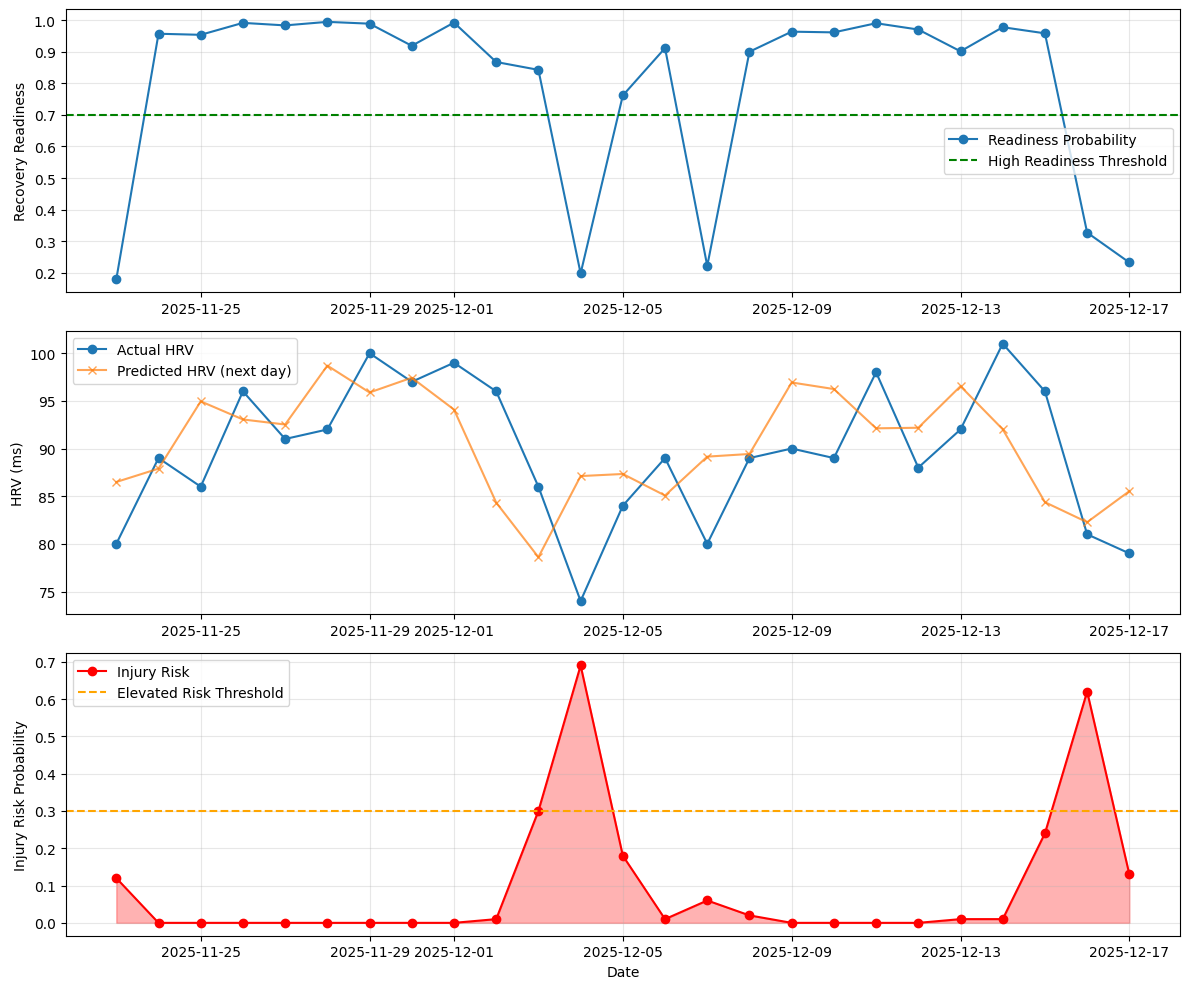

In [5]:
# Cell 3: Visualize (UPDATED)
import matplotlib.pyplot as plt
import numpy as np

recent = df.tail(30).copy()

recovery_preds = []
hrv_preds = []
injury_risks = []

for idx, row in recent.iterrows():
    try:
        X_rec = row[recovery_features].to_frame().T
        recovery_preds.append(recovery_model.predict_proba(X_rec)[0][1])
        
        X_hrv = row[config['hrv_features']].to_frame().T
        hrv_preds.append(hrv_model.predict(X_hrv)[0])
        
        X_inj = row[config['injury_features']].to_frame().T
        injury_risks.append(injury_model.predict_proba(X_inj)[0][1])
    except:
        recovery_preds.append(np.nan)
        hrv_preds.append(np.nan)
        injury_risks.append(np.nan)

recent['recovery_readiness'] = recovery_preds
recent['predicted_hrv'] = hrv_preds
recent['injury_risk'] = injury_risks

# Plot (same as before)
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

axes[0].plot(recent['date'], recent['recovery_readiness'], marker='o', label='Readiness Probability')
axes[0].axhline(0.7, color='green', linestyle='--', label='High Readiness Threshold')
axes[0].set_ylabel('Recovery Readiness')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(recent['date'], recent['hrv_rmssd'], marker='o', label='Actual HRV')
axes[1].plot(recent['date'], recent['predicted_hrv'], marker='x', label='Predicted HRV (next day)', alpha=0.7)
axes[1].set_ylabel('HRV (ms)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(recent['date'], recent['injury_risk'], marker='o', color='red', label='Injury Risk')
axes[2].axhline(0.3, color='orange', linestyle='--', label='Elevated Risk Threshold')
axes[2].fill_between(recent['date'], 0, recent['injury_risk'], alpha=0.3, color='red')
axes[2].set_ylabel('Injury Risk Probability')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
